## Setup and Load Data

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib 

In [3]:
import tensorflow as tf 
import os 
from matplotlib import pyplot as plt 
import numpy as np 
import pandas as pd 

In [11]:
# avoid OOM error by limiting GPU memory consumption 
gpus = tf. config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) 

### Load Data

In [ ]:
 #   for tf dataset pipeline documentation run this code, otherwise skip it 
 tf.data.Dataset??

In [ ]:
tf.keras.utils.image_dataset_from_directory??

In [5]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 13853 files belonging to 22 classes.


In [12]:
data_iterator = data.as_numpy_iterator() 
data_iterator

In [13]:
# images represented as numpy arrays in batches of 32 images (check documentation )
batch = data_iterator.next() 

In [17]:
#labels 
batch[1]

array([13, 15, 14, 18, 12, 14,  9, 10, 16,  1, 14, 15,  8,  8,  4,  6, 11,
        7, 12,  3,  5, 16, 11,  3,  8,  9,  1,  7, 13,  8,  7,  3])

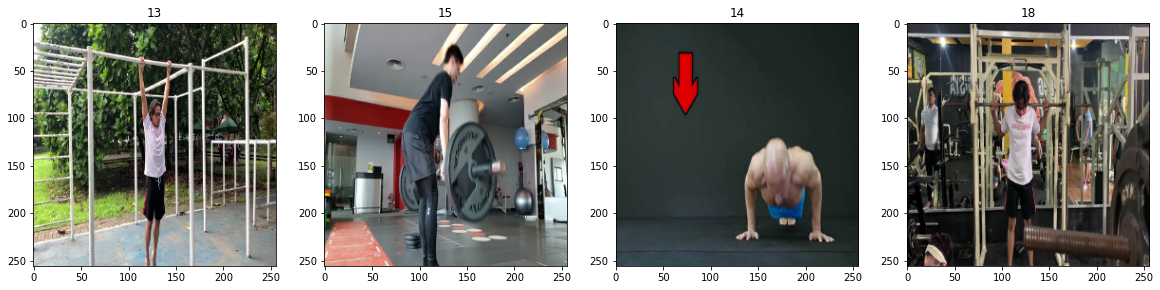

In [18]:
#check the some images of the batch with their respective class 

fig, ax = plt.subplots(ncols=4, figsize = (20, 20))

for idx, img in enumerate (batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
#